In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.base import BaseEstimator
class Drop_columns(BaseEstimator,TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def transform(self, X, y=None, **kwargs):
        try:
            return X.drop(self.columns, axis=1)
        except ValueError:
            print ('No such columns!')
            
    def fit(self, X, y=None, **kwargs):
        return self

class DummyEncoder(BaseEstimator,TransformerMixin):

    def __init__(self, columns=None):

        self.columns = columns

    def transform(self, X, y=None, **kwargs):

        return pd.get_dummies(X, columns=self.columns, drop_first=True)

    def fit(self, X, y=None, **kwargs):

        return self
    
class Encoder(BaseEstimator,TransformerMixin):
    
    def __init__(self, columns=None):
        
        self.columns = columns
    
    def transform(self, X, y=None, **kwargs):
        
        le = LabelEncoder()
        for col in self.columns:
            X[col] = le.fit_transform(X[col])
        return X
    
    def fit(self, X, y=None, **kwargs):
        
        return self

def display_result(X_train, X_test, y_train, y_test, clf, display_roc=True):
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print (classification_report(y_test, y_pred))


    matrix = pd.DataFrame(
           confusion_matrix(y_test,y_pred),
            columns=['Predicted False', 'Predict True'],
            index = ['Actual False', 'Actual True'])
    print (matrix)
    
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    if display_roc:
        
        plt.plot(fpr, tpr,label='%s (area = %0.2f)' % ('LogisticRegression', roc_auc_score(y_test, y_pred)))
        # Plot Base Rate ROC
        plt.plot([0,1], [0,1],label='Base Rate' 'k--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Graph')
        plt.legend(loc="lower right")
        plt.show()
        return
    return fpr, tpr, thresholds, y_pred

def read_data(onehot=False, label=False, return_cat_columns=False):
    df = pd.read_csv('churn.csv')
    df.columns = df.columns.str.lower().str.replace(' ','_')
    df.rename(columns={'churn?':'churn', "int'l_plan":'intl_plan'}, inplace=True)
    df = (df.drop(['phone','day_charge','eve_charge','night_charge','intl_charge'], axis=1)
            .replace(['True.','False.'],[1,0]))
    df.area_code = df.area_code.astype('object')
    if label:
        df = df.replace(['yes','no'],[1,0])
    if onehot:
        df = pd.get_dummies(df, columns=['state','area_code'], drop_first=True)
    if return_cat_columns:
        return df, df.dtypes[df.dtypes==object].index.values.tolist()
    else:
        return df

### 1. Baseline Model

In [3]:
df, cat_cols = read_data(return_cat_columns=True)
X_train, X_test, y_train, y_test = train_test_split(df.drop('churn', axis=1), df.churn.values, test_size=0.2,
                                                   random_state=0)

In [4]:
cols = ['area_code', 'intl_plan', 'vmail_plan']

Logistic Regression
             precision    recall  f1-score   support

          0       0.96      0.60      0.74       579
          1       0.24      0.83      0.37        88

avg / total       0.86      0.63      0.69       667

              Predicted False  Predict True
Actual False              350           229
Actual True                15            73
Logistic Regression drop State
             precision    recall  f1-score   support

          0       0.97      0.63      0.77       579
          1       0.27      0.89      0.41        88

avg / total       0.88      0.67      0.72       667

              Predicted False  Predict True
Actual False              366           213
Actual True                10            78
Decision Tree
             precision    recall  f1-score   support

          0       0.97      0.92      0.94       579
          1       0.60      0.78      0.68        88

avg / total       0.92      0.90      0.91       667

              Predicted Fa

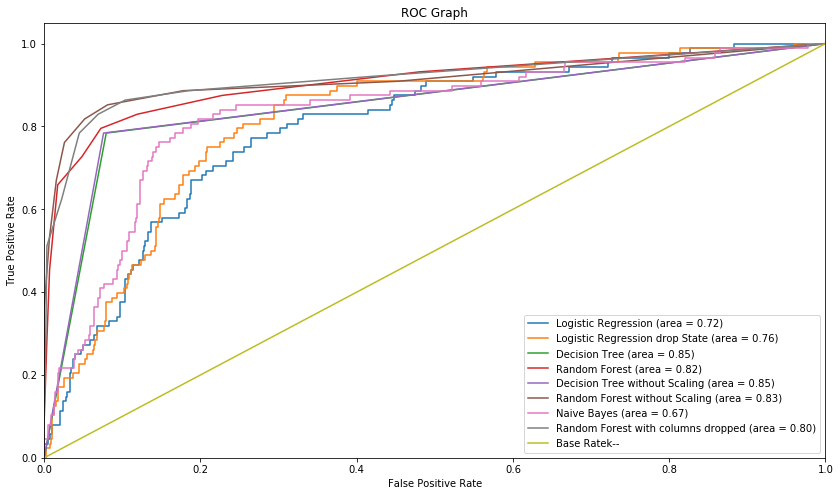

In [5]:
plt.figure(figsize=(14,8))
lr = make_pipeline(DummyEncoder(), StandardScaler(), LogisticRegression(fit_intercept=False))
lrd = make_pipeline(Drop_columns(columns=['state']),Encoder(columns=cols),StandardScaler(),
                    LogisticRegression(fit_intercept=False))
dc = make_pipeline(Encoder(columns=cat_cols), StandardScaler() ,DecisionTreeClassifier())
dc2 = make_pipeline(Encoder(columns=cat_cols), DecisionTreeClassifier())
rf = make_pipeline(Encoder(columns =cat_cols), StandardScaler(), RandomForestClassifier())
rfn = make_pipeline(Encoder(columns=cat_cols), RandomForestClassifier())
rfd = make_pipeline(Drop_columns(columns=['state','area_code']),Encoder(columns=['intl_plan','vmail_plan']),
                   RandomForestClassifier())
nb = make_pipeline(Encoder(columns=cat_cols), GaussianNB())
models = [('Logistic Regression', lr),('Logistic Regression drop State', lrd),('Decision Tree', dc),
         ('Random Forest', rf),('Decision Tree without Scaling', dc2),('Random Forest without Scaling', rfn),
         ('Naive Bayes', nb),('Random Forest with columns dropped',rfd)]
for model_name, clf in models:
    print (model_name)
    fpr, tpr, thresholds, y_pred = display_result(X_train, X_test, y_train, y_test, clf, display_roc=False)
    plt.plot(fpr, tpr,label='%s (area = %0.2f)' % (model_name, roc_auc_score(y_test, y_pred)))
    

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")

plt.show()
#display_result(X_train, X_test,y_train,y_test, lr)
#display_result(X_train, X_test, y_train, y_test, lrd)

On the whole, Random Forest model has the best balance, with decent precision and recall. In term of accuracy on true positive, Logistic Regression does the best, but at the expense of naming a large portion of customers as churn (False positive). Thus, for a model to be better, we must improve upon Random Forest's accuracy on true postive without sacrificing too much on false negative and postive. 

### 2. Hyper Parameter Tuning

In this section, we will try to tune two models: Random Forest Classifier and the popular XGBoost Classifier. Because we have imbalance data, we choose f1_weighted as our score in grid search. Also, the scale_pos_weight parameter for XGBClassifier also allow ones to fine tune result with more emphasis on recall.

In [6]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#from evolutionary_search import EvolutionaryAlgorithmSearchCV

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

### Random Forest Classifier

             precision    recall  f1-score   support

          0       0.97      0.98      0.97       579
          1       0.85      0.81      0.83        88

avg / total       0.95      0.96      0.95       667

              Predicted False  Predict True
Actual False              566            13
Actual True                17            71


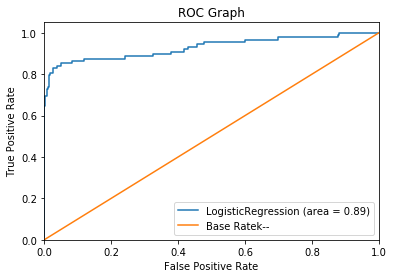

In [8]:
rf_pipeline =  make_pipeline(Drop_columns(columns=['state','area_code']), 
                        Encoder(columns=['intl_plan','vmail_plan']),
                        RandomForestClassifier())

grid = {
    'randomforestclassifier__n_estimators': [10,20,50,100,200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    "randomforestclassifier__max_features": [3, 5],
    "randomforestclassifier__max_depth" : [5,6,7,8,9,10],
    "randomforestclassifier__min_samples_split" : [2, 4] ,
}

clf_rf = GridSearchCV(rf_pipeline, grid, cv=cv, n_jobs=-1, scoring='f1_weighted')
display_result(X_train, X_test, y_train, y_test, clf_rf)

### XGBoost Classifier

**Note**: with the number of possible choice of parameters, it will take too long for GridSearchCV, and we will use RandomizedSearchCV with subsample of 400 parameter choice, instead.

In [32]:
ind_params = {'objective':'binary:logistic',
              'nthread':-1,
              'seed': 42}

param_grid =  {'xgbclassifier__max_depth':[6,7,8,9,10],
         'xgbclassifier__n_estimators':[70,80,90,100,120,130,140],
         'xgbclassifier__learning_rate': [0.01,0.05,0.0005],
         'xgbclassifier__min_child_weight':[5,6,7,8,9],
         'xgbclassifier__gamma': [i/10 for i in range(0,5)],
         'xgbclassifier__scale_pos_weight':[4.0,3.0,2.0,1.5,1.0]}

             precision    recall  f1-score   support

          0       0.98      0.97      0.97       579
          1       0.79      0.84      0.81        88

avg / total       0.95      0.95      0.95       667

              Predicted False  Predict True
Actual False              559            20
Actual True                14            74


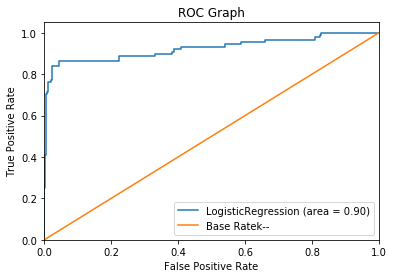

In [10]:
#Warning: this take a long time to run.
#It's better to preprocess the data separately without using pipeline.

xgb = make_pipeline(Drop_columns(columns=['state','area_code']), 
                    Encoder(columns=['intl_plan','vmail_plan']),
                    XGBClassifier(**ind_params))
clf = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=100,cv=cv, n_jobs=-1, scoring='f1_weighted')
display_result(X_train, X_test, y_train, y_test, clf)

There are not much separating the two models. Except with fewer parameters to try out, the Random Forest model is a lot faster to tune. Part of the reason for the slowness of the XGBoost model is due to using sklearn Pipeline since it preprocess data for each new parameters. Preprocess the data once, speed up the process significantly with the cost of messier code.

### SMOTE + Tomek Resampling Method

In the last section of this churn analysis, I want to give a brief experiment of the systhetic resampling method. In my experience, SMOTE alone doesn't necessary give a significant boost in accuracy. However, SMOTE+Tomek from [this presentation](https://www.youtube.com/watch?v=-Z1PaqYKC1w&t=2362s) seems promising. Let's see if it will improve our result.

In [28]:
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from imblearn.combine import SMOTETomek

scaler = StandardScaler()
x_train = X_train.copy()
x_test = X_test.copy()
x_train.drop(['state','area_code'], axis=1, inplace=True)
x_test.drop(['state','area_code'], axis=1, inplace=True)

cols = x_train.columns

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


os_us = SMOTETomek(ratio=0.5, k=5)
x_train_res, y_train_res = os_us.fit_sample(x_train, y_train)

#X_train_res = pd.DataFrame(X_train_res, columns=cols)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


**1. Random Forest Classifier**

             precision    recall  f1-score   support

          0       0.98      0.96      0.97       579
          1       0.76      0.85      0.80        88

avg / total       0.95      0.94      0.95       667

              Predicted False  Predict True
Actual False              555            24
Actual True                13            75


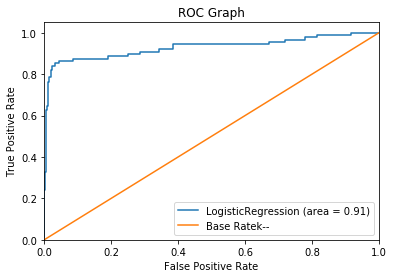

In [29]:
clf_base =  RandomForestClassifier()

grid = {
    'n_estimators': [10,20,50,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    "max_features": [3, 5],
    "max_depth" : [5,6,7,8,9,10],
    "min_samples_split" : [2, 4] ,
}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf_rf_smote = GridSearchCV(clf_base, grid, cv=cv, n_jobs=-1, scoring='f1_weighted')

display_result(x_train_res, x_test, y_train_res, y_test, clf_rf_smote)

** 2. XGBoost Classifier**

             precision    recall  f1-score   support

          0       0.98      0.94      0.96       579
          1       0.70      0.85      0.77        88

avg / total       0.94      0.93      0.94       667

              Predicted False  Predict True
Actual False              547            32
Actual True                13            75


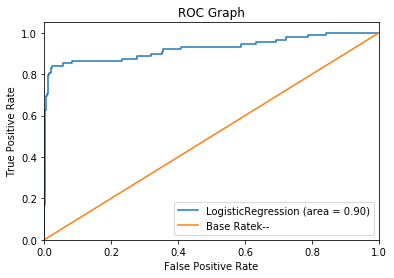

In [31]:
xgb_grid =  {'max_depth':[6,7,8,9,10],
             'n_estimators':[70,80,90,100,120,130,140],
             'learning_rate': [0.01,0.05,0.0005],
             'min_child_weight':[5,6,7,8,9],
             'gamma': [i/10 for i in range(0,5)],
             'scale_pos_weight':[4.0,3.0,2.0,1.5,1.0]}

xgb = XGBClassifier(**ind_params)
clf = RandomizedSearchCV(xgb, param_distributions=xgb_grid,cv=cv, n_iter=100, n_jobs=-1, scoring='f1_weighted')
display_result(x_train_res, x_test, y_train_res, y_test, clf)

The resampling method seems to increase the false positive rate a bit with little gain on true positive. On balance, the best result is the Random Forest Classifier model without resampling. Although its true positive rate is slightly lower than the XGBoost classifier model, it strikes the best balance in precision, with low false positive and negative rate. 

With the massive number of parameters to tune, it is possible to tune the XGBoost Classifier model further. However, the Random Forest Classifier model result looks good enough that, in the interest of time, I will leave the result as it is. 

In the next section, I will compare the Random Forest Classifier result to that of LightGBM Classifier, which is a new comer that is quickly gaining popularity, due to comparable result to XGBoost, but significantly faster.